# Library Import


In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from Crypto.Hash import SHA3_256
from Crypto.Cipher import ChaCha20_Poly1305
from Crypto.Random import get_random_bytes
params = {"ytick.color": "black",
          "xtick.color": "black",
          "axes.labelcolor": "black",
          "axes.edgecolor": "black",
          "text.usetex": True,
          "font.family": "serif",
          "font.serif": ["Computer Modern Serif"]}
plt.rcParams.update(params)

# E91


# SHA-3 Digest


In [4]:
with open('aliceKey.bin', 'rb') as f:
    aliceKey = f.read()
print("Alice's Key: ", aliceKey)
hashObject = SHA3_256.new()
hashObject.update(aliceKey)
key = hashObject.digest()
print("Hash of Alice's key: ", key)

Alice's Key:  b'\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\\I>\xef\xbf\xbdP\xef\xbf\xbd\xc4\x98j\xef\xbf\xbd\r\n'
Hash of Alice's key:  b'\xadu\x11\xfb\x87[y0\x86\x96\x91F\xa2\xf0Z\xf0\xa5=\xf3x\x1aT\x05\xd4\x8b#\xf8\xfd\xb0\xbf\xce\xee'


# Steganography


## Function Definition


### Embedding


#### Audio Clipping Function


In [5]:
def clip_audio(audio_data, min_value=-32768, max_value=32767):
    return np.clip(audio_data, min_value, max_value)

#### Audio Embedding Function


In [6]:
def embed_audio(carrier_path, secret_path, output_path, num_bits=8):
    # Open the carrier and secret audio files
    carrier = wave.open(carrier_path, 'rb')
    secret = wave.open(secret_path, 'rb')
    # Ensure compatibility between carrier and secret audio
    if carrier.getnchannels() != secret.getnchannels() or carrier.getsampwidth() != secret.getsampwidth():
        raise ValueError(
            "Carrier and secret audio must have the same number of channels and sample width.")
    # Read audio data
    carrier_frames = np.frombuffer(carrier.readframes(
        carrier.getnframes()), dtype=np.int16)
    secret_frames = np.frombuffer(secret.readframes(
        secret.getnframes()), dtype=np.int16)
    # Ensure carrier has enough capacity to store secret
    max_secret_length = len(carrier_frames) // (16 // num_bits)
    if len(secret_frames) > max_secret_length:
        raise ValueError(f"Carrier audio cannot hold the secret audio. Max capacity: {
                         max_secret_length}, got: {len(secret_frames)}.")
    # Resize the secret frames to match embedding capacity
    padded_secret_frames = np.zeros(max_secret_length, dtype=np.int16)
    padded_secret_frames[:len(secret_frames)] = secret_frames
    # Embed the secret audio into the carrier
    embedded_frames = np.copy(carrier_frames)
    mask = (1 << num_bits) - 1  # Mask to isolate the LSBs
    embedded_frames &= ~mask  # Clear the least significant bits
    embedded_frames[:len(padded_secret_frames)] += (padded_secret_frames >>
                                                    # Embed secret bits
                                                    (16 - num_bits)) & mask
    # Clip audio values to valid range
    embedded_frames = clip_audio(embedded_frames)
    # Write the embedded audio to a new file
    embedded_audio = wave.open(output_path, 'wb')
    embedded_audio.setparams(carrier.getparams())
    embedded_audio.writeframes(embedded_frames.astype(np.int16).tobytes())
    # Close files
    carrier.close()
    secret.close()
    embedded_audio.close()
    print(f"Embedding complete. Saved to {output_path}")

### Extraction


In [7]:
def extract_audio(embedded_path, secret_output_path, secret_length, num_bits=8):
    # Open the embedded audio file
    embedded = wave.open(embedded_path, 'rb')
    # Read audio data
    embedded_frames = np.frombuffer(embedded.readframes(
        embedded.getnframes()), dtype=np.int16)
    # Extract the secret audio
    mask = (1 << num_bits) - 1  # Mask to isolate the embedded bits
    extracted_bits = (embedded_frames & mask) << (16 - num_bits)
    secret_frames = extracted_bits[:secret_length*2]
    # Apply a low-pass filter to reduce noise
    secret_frames = np.convolve(secret_frames, np.ones(
        5)/5, mode='same')  # Simple smoothing (moving average)
    # Clip audio values to valid range
    secret_frames = clip_audio(secret_frames)
    # Write the secret audio to a new file
    secret_audio = wave.open(secret_output_path, 'wb')
    secret_audio.setparams(embedded.getparams())
    secret_audio.setnframes(secret_length)
    secret_audio.writeframes(secret_frames.astype(np.int16).tobytes())
    # Close files
    embedded.close()
    secret_audio.close()
    print(f"Extraction complete. Secret audio saved to {secret_output_path}")

## Implementation


### Input


In [8]:
# Carrier audio
carrier_audio = "cover.wav"
secret_audio = "secret2.wav"  # Secret audio
embedded_audio = "embedded2.wav"  # Output for the embedded audio

### Embed


In [9]:
embed_audio(carrier_audio, secret_audio, embedded_audio, num_bits=8)

Embedding complete. Saved to embedded2.wav


# Encryption, Decryption, MAC Generation and Authentication


## Function Definitions


Encryption using the SHA3-256 digest of the final Ekert key.


In [10]:
def encryptAudio(key, inputFile, outputFile, outputAudio):
    with open(inputFile, 'rb') as inputFile:
        audioData = inputFile.read()
    header = b"Stego Audio"
    cipher = ChaCha20_Poly1305.new(key=key)
    cipher.update(header)
    nonce = cipher.nonce
    print("Nonce: ", nonce.hex())
    ciphertext, tag = cipher.encrypt_and_digest(audioData)
    print("Tag: ", tag.hex())
    with open(outputAudio, 'wb') as outputAudio:
        outputAudio.write(ciphertext)
    with open(outputFile, 'wb') as outputFile:
        outputFile.write(nonce+ciphertext+tag)

Applying random bit flip to encrypted audio in order to simulate middle-man attack


In [11]:
def addNoise(inputFile, noisyOutputFile):
    with open(inputFile, 'rb') as inputFile:
        noisyCiphertextBytes = bytearray(inputFile.read())
        for x in range(100000):
            indexToModify = np.random.randint(0, len(noisyCiphertextBytes)-1)
            noisyCiphertextBytes[indexToModify] ^= np.random.randint(
                0x00, 0xFF)
        with open(noisyOutputFile, 'wb') as noisyOutputFile:
            noisyOutputFile.write(noisyCiphertextBytes)

Decryption


In [12]:
def decryptAudio(key, inputFile, outputFile):
    with open(inputFile, 'rb') as inputFile:
        data = inputFile.read()
        nonce = data[:12]
        ciphertext = data[12:-16]
        tag = data[-16:]
    header = b"Stego Audio"
    cipher = ChaCha20_Poly1305.new(key=key, nonce=nonce)
    cipher.update(header)
    try:
        decryptedAudio = cipher.decrypt_and_verify(ciphertext, tag)
        with open(outputFile, 'wb') as outputFile:
            outputFile.write(decryptedAudio)
            print("Nonce: ", nonce.hex())
            print("Tag: ", tag.hex())
            print("Decryption and verification successful!")
    except ValueError:
        print("Verification failed!")

## Implementation


In [13]:
inputAudio = "embedded2.wav"
outputAudio = "encrypted2.wav"
output = "encrypted2.bin"
decryptedAudio = "decrypted2.wav"

In [14]:
encryptAudio(key, inputAudio, output, outputAudio)

Nonce:  41d1bcd34873575ad5a02988
Tag:  19c6070362fafdafe6c085d6c2f4717c


In [15]:
addNoise("encrypted2.bin", "noisy2.bin")
noisyOutput = "noisy2.bin"

In [16]:
decryptAudio(key, output, decryptedAudio)

Nonce:  41d1bcd34873575ad5a02988
Tag:  19c6070362fafdafe6c085d6c2f4717c
Decryption and verification successful!


In [17]:
decryptAudio(key, noisyOutput, "outfile.bin")

Verification failed!


# Extraction


In [18]:
extracted_audio = "extracted2.wav"
# extract_audio('embedded.wav', 'output.wav', 8)

secret_audio_length = wave.open(
    secret_audio, 'rb').getnframes()  # Length of the secret audio
extract_audio(embedded_audio, extracted_audio, secret_audio_length)

Extraction complete. Secret audio saved to extracted2.wav


# Analysis


Add embedded.wav and encrypted.bin as argument

In [2]:
def createByteArray(embeddedFile, encryptedBinFile):
    # Read embedded file as 16-bit integers (no slicing)
    with open(embeddedFile, 'rb') as f:
        embedded_data = f.read()
    embedded_audio = np.frombuffer(embedded_data, dtype=np.uint16)  # or uint16

    # Read encrypted file and slice ciphertext (bytes 12 to -16)
    with open(encryptedBinFile, 'rb') as f:
        data = f.read()
    ciphertext = data[12:-16]  # Same byte slicing as before
    encrypted_audio = np.frombuffer(
        ciphertext, dtype=np.uint16)  # 16-bit values

    return [embedded_audio, encrypted_audio]

## Entropy Calculation and Comparison

In [12]:
def calculateEntropy(embeddedFile, encryptedBinFile):
    embeddedAudio, encryptedAudio = createByteArray(
        embeddedFile, encryptedBinFile)
    audioFiles = [embeddedAudio, encryptedAudio]
    for x in audioFiles:
        hist, _ = np.histogram(x, bins=65536, range=(0, 65536))
        # Calculate probability distribution
        probabilities = hist / len(x)
        # Remove zeros from probabilities (to avoid log2(0) errors)
        probabilities = probabilities[probabilities > 0]
        # Calculate entropy
        entropy = -np.sum(probabilities * np.log2(probabilities))
        if np.all(x == embeddedAudio):
            print("Entropy of Original Audio: ", entropy)
        else:
            print("Entropy of Encrypted Audio: ", entropy)

In [15]:
calculateEntropy('decrypted2.wav', 'encrypted2.bin')

Entropy of Original Audio:  9.792556077074044
Entropy of Encrypted Audio:  15.998420782458867


## Correlation Calculation

In [3]:
# def calculateCorrelation(embeddedFile, encryptedBinFile):
#     embeddedAudio, encryptedAudio = createByteArray(
#         embeddedFile, encryptedBinFile)
#     correlation = np.corrcoef(embeddedAudio, encryptedAudio)[0, 1]
#     print("Correlation Coefficient:", correlation)
def calculateCorrelation(embeddedFile, encryptedBinFile):
    embeddedAudio, encryptedAudio = createByteArray(
        embeddedFile, encryptedBinFile)

    # Calculate correlation coefficient between adjacent samples for embedded audio
    embedded_corr_coef = np.corrcoef(
        embeddedAudio[:-1], embeddedAudio[1:])[0, 1]

    # Calculate correlation coefficient between adjacent samples for encrypted audio
    encrypted_corr_coef = np.corrcoef(
        encryptedAudio[:-1], encryptedAudio[1:])[0, 1]

    print("Correlation Coefficient (Embedded Audio):", embedded_corr_coef)
    print("Correlation Coefficient (Encrypted Audio):", encrypted_corr_coef)

In [17]:
calculateCorrelation('decrypted2.wav', 'encrypted1.bin')

Correlation Coefficient (Embedded Audio): 0.5437499517001024
Correlation Coefficient (Encrypted Audio): -1.9215651532491242e-05


## UACI Calculation

In [5]:
def calculateUACI(embeddedFile, encryptedBinFile):
    embeddedAudio, encryptedAudio = createByteArray(
        embeddedFile, encryptedBinFile)
    maxVal = np.max(np.abs(embeddedAudio))
    diff = np.abs(np.subtract(embeddedAudio, encryptedAudio))
    uaci = (np.sum(diff)/len(diff))/maxVal*100
    print(maxVal)
    print("UACI: ", uaci)

In [18]:
calculateUACI('embedded2.wav', 'encrypted2.bin')

65535
UACI:  49.99185254293764


## NSCR Calculation

In [8]:
def calculateNSCR(embeddedFile, encryptedBinFile):
    embeddedAudio, encryptedAudio = createByteArray(
        embeddedFile, encryptedBinFile)
    nscr = 0
    for i in range(len(embeddedAudio)):
        if embeddedAudio[i] != encryptedAudio[i]:
            nscr += 1
    nscr = nscr/len(embeddedAudio)*100
    print("NSCR: ", nscr)

In [20]:
calculateNSCR('embedded2.wav', 'encrypted2.bin')

NSCR:  99.9984527787054


## Histogram Plot

In [2]:
def plotHistogram(inputFile):
    with open(inputFile, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.int16)
    plt.hist(data, bins='auto', linewidth=2)
    fileName = inputFile.split('.')[0]+'Histogram'+'.png'
    plt.savefig(fileName, format='png', dpi=600)
    plt.show

## Spectrogram Plot

In [12]:
def plotSpectrogram(inputFile):
    with open(inputFile, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.int32)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.specgram(data, Fs=44100)
    fileName = inputFile.split('.')[0]+'Spectrogram'+'.png'
    plt.savefig(fileName, format='png', dpi=600)
    plt.show

## Correlation Map

In [19]:
def plotCorrelation(inputFile):
    with open(inputFile, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.int16)
        plt.scatter(data, np.roll(data, 1), s=1, marker=".")
        fileName = inputFile.split('.')[0]+'Correlation'+'.png'
        plt.savefig(fileName, format='png', dpi=600)
        plt.show

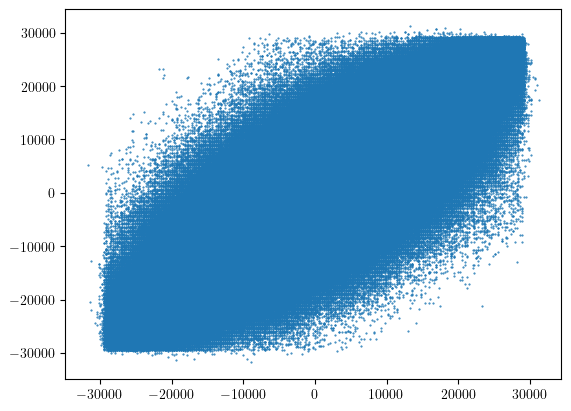

In [25]:
plotCorrelation('decrypted2.wav')